##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

##### Original code
https://github.com/MokkeMeguru/glow-realnvp-tutorial/

If you have any Problem, please let me(@MokkeMeguru) it.

In [21]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TFP Bijector: Glow x MNIST

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/glow_mnist.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/glow_mnist.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this example we show how to build a Glow using TFP's "Bijector."

# Glow

Difference from RealNVP 

- Invertible 1x1 convolution
- Actnorm

## Invertible 1x1 convolution

RealNVP uses Permutation by the channel dimention for Affine Coupling Layer. (Intuitively、we want to replace $x_a$ and $x_b$, I think...)

In Glow, the Permutaion is changed to the Invertible 1x1 convolution he proposed. It's a learnable layer (bijector).

formula

1. forward function
2. reverse function
3. log determinant

## Actnorm
Instead of Batch Normalization

Week points of Batch Normalization
1. IF batch size is small, it may decrease performance. (In flow base model, Batch size is often too small since this model needs large memory...)


Behavior of Actnorm
1. normalize by **channel-wise** , using the **first batch**
2. initialize weights by the normalize parameter. (bias and scale)
3. learn these weights since next batch.

# Problem Setting
Multivariate normal distribution $\leftrightarrow$ MNIST dataset

# Use Tensorflow
## Implementation Plan
0. Preprocess
1. Create Dataset
2. Build Multi-Scale Model
    1. Invertible 1x1 convolution Bijector
    2. Actnorm Bijector
    3. Multi-Scale Model
4. Build Model
    1. TransformDistribution
    2. Loss, Optimizar
    3. Training
    4. Inference

## Preprocess

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import Model

tfd = tfp.distributions
tfb = tfp.bijectors

print('tensorflow: ', tf.__version__)
print('tensorflow-probability: ', tfp.__version__)

tensorflow:  2.0.0-rc0
tensorflow-probability:  0.8.0-rc0


## Create Dataset
ref. [realnvp's tutorial](./RealNVP_mnist_en.ipynb)

### Create Target Distibution ($z$)
In this part, use Multivariate normal distribution

In [2]:
# Tensorflow's distribution
z = tf.random.normal([2, 2, 256])
print('Tensorflow             : shape: {} mean: {:.6f} sd: {:.6f}'.format(z.shape, tf.math.reduce_mean(z), tf.math.reduce_std(z)))
# Tensorflow Probability's distribution
target_dist = tfd.Normal(loc=0., scale=1.)
z = target_dist.sample([2, 2, 256])
print('Tensorflow Probability : shape: {} mean: {:.6f} sd: {:.6f}'.format(z.shape, tf.math.reduce_mean(z), tf.math.reduce_std(z)))

Tensorflow             : shape: (2, 2, 256) mean: -0.002196 sd: 1.050574
Tensorflow Probability : shape: (2, 2, 256) mean: -0.022014 sd: 1.020308


### Create Original Distribution (MNIST)

In [5]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

print('train_dataset: {} images'.format(len(train_x)))
print('test_dataset : {} images'.format(len(test_x)))

train_dataset: 60000 images
test_dataset : 10000 images


In [6]:
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 64


@tf.function
def _parse_function(img, label):
    feature = {}
    img = tf.pad(img, paddings=[[2, 2], [2, 2]], mode="CONSTANT")
    img = tf.expand_dims(img, axis=-1)
    img = tf.reshape(img, [32, 32, 1])
    img = tf.cast(img, dtype=tf.float32)
    img = (img / (255.0 / 2)) - 1
    feature["img"] = img
    feature["label"] = label
    return feature


train_dataset_raw = tf.data.Dataset.from_tensor_slices((train_x, train_y)).map(
    _parse_function
)
test_dataset_raw = tf.data.Dataset.from_tensor_slices((test_x, test_y)).map(
    _parse_function
)

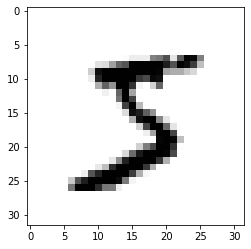

In [7]:
for image_features in train_dataset_raw.take(1):
    plt.imshow(tf.squeeze(image_features['img'], axis=-1), cmap='gray_r')

## Build Multi-Scale Model

### Invertive 1x1 convolution Bijector
ref. 
- Tensorflow Probability's implementation tensorflow_probability/bijector/MatvecLU 
- the issue https://github.com/tensorflow/probability/issues/545 

In [8]:
def trainable_lu_factorization(event_size,
                               batch_shape=(),
                               seed=None,
                               dtype=tf.float32,
                               name=None):
    with tf.name_scope('trainable_lu_factorization'):
        event_size = tf.convert_to_tensor(event_size,
                                          dtype=tf.int32,
                                          name='event_size')
        batch_shape = tf.convert_to_tensor(batch_shape,
                                           dtype=event_size.dtype,
                                           name='batch_shape')
        random_matrix = tf.Variable(tf.random.uniform(
            shape=tf.concat([batch_shape, [event_size, event_size]], axis=0),
            dtype=dtype,
            seed=seed,
        ),
                                    name='conv1x1_weights')

        def lu_p(m):
            return tf.linalg.lu(tf.linalg.qr(m).q)

        # lower_upper = tfp.util.DeferredTensor(lambda m: lu_p(m)[0],
        #                                       random_matrix)
        # permutation = tfp.util.DeferredTensor(lambda m: lu_p(m)[1],
        #                                       random_matrix,
        #                                       # trainable=False,
        #                                       dtype=tf.int32,
        #                                       shape=random_matrix.shape[:-1])
        lower_upper = tf.Variable(lu_p(random_matrix)[0], name='lower_upper')
        # ref https://github.com/tensorflow/probability/issues/545
        permutation = tf.Variable(lu_p(random_matrix)[1], trainable=False, name='permutation')
        return lower_upper, permutation


def build_model(channels=3):
    # conv1x1 setup
    t_lower_upper, t_permutation = trainable_lu_factorization(channels)
    conv1x1 = tfb.MatvecLU(t_lower_upper, t_permutation, name='MatvecLU')
    print('conv1x1 variable\n', conv1x1.variables)
    inv_conv1x1 = tfb.Invert(conv1x1)

    # forward setup
    fwd = tfp.layers.DistributionLambda(
        lambda x: conv1x1(tfd.Deterministic(x)))
    fwd.vars = conv1x1.trainable_variables

    # inverse setup
    inv = tfp.layers.DistributionLambda(
        lambda x: inv_conv1x1(tfd.Deterministic(x)))
    inv.vars = inv_conv1x1.trainable_variables
    
    x: tf.Tensor = tf.keras.Input(shape=[28, 28, channels])
    fwd_x: tfp.distributions.TransformedDistribution = fwd(x)
    rev_fwd_x: tfp.distributions.TransformedDistribution = inv(fwd_x)
    example_model = tf.keras.Model(inputs=x, outputs=rev_fwd_x, name='conv1x1')
    return example_model


def test_conv1x1():
    example_model = build_model()
    example_model.trainable = True
    example_model.summary()

    real_x = tf.random.uniform(shape=[2, 28, 28, 3], dtype=tf.float32)
    if example_model.weights == []:
        print('No Trainable Variable exists')
    else:
        print('Some Trainable Variables exist')

    with tf.GradientTape() as tape:
        tape.watch(real_x)
        out_x = example_model(real_x)
        out_x = out_x
        loss = out_x - real_x
    print(tf.math.reduce_sum(real_x - out_x))
    # => nealy 0
    # ex. tf.Tensor(1.3522818e-05, shape=(), dtype=float32)

    try:
        print(tape.gradient(loss, real_x).shape)
    except Exception as e:
        print('Cannot Calculate Gradient')
        print(e)
        
test_conv1x1()

conv1x1 variable
 (<tf.Variable 'trainable_lu_factorization/lower_upper:0' shape=(3, 3) dtype=float32, numpy=
array([[-0.81331706, -0.4522668 ,  0.36601922],
       [ 0.66093314,  1.1237284 , -0.41721344],
       [ 0.27371168, -0.19180459, -1.0941547 ]], dtype=float32)>, <tf.Variable 'trainable_lu_factorization/permutation:0' shape=(3,) dtype=int32, numpy=array([2, 0, 1], dtype=int32)>)
Model: "conv1x1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
distribution_lambda (Distrib ((None, 28, 28, 3), (None 9         
_________________________________________________________________
distribution_lambda_1 (Distr ((None, 28, 28, 3), (None 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Some 

### Actnorm Bijector
Notice: Initialize by the **First Batch**

※ By the way, Actnorm implementation by OpenAI https://github.com/openai/glow/blob/master/tfops.py#L71-L87　is not same as their paper's formula, I think...     
Forward's formula may be $(x + b) \odot s$ ...

In [9]:
class Actnorm(tfb.Bijector):
    def __init__(self, channels:int, validate_args=False, name='actnorm', log_scale_factor=1.0):
        super(Actnorm, self).__init__(
            # this bijector affect vector-wise (channel-wise) => forward_min_event_ndims=1
            forward_min_event_ndims=1,
            validate_args=validate_args,
            name=name
        )
        self.log_scale_factor = log_scale_factor
        self.initialized = False
        self.log_scale = tf.Variable(tf.random.normal([channels]))
        self.bias = tf.Variable(tf.random.normal([channels]))
        
    def setStat(self, x):
        mean = tf.math.reduce_mean(x, axis=[0, 1, 2])
        var = tf.math.reduce_mean((x - mean) ** 2, axis=[0, 1, 2])
        stdvar = tf.math.sqrt(var) + 1e-6
        log_scale = tf.math.log(1./ stdvar / self.log_scale_factor) * self.log_scale_factor
        self.bias.assign(- mean)
        self.log_scale.assign(log_scale)

    def _forward(self, x):
        if not self.initialized:
            self.setStat(x)
            self.initialized = True
        return (x + self.bias) * tf.exp(self.log_scale)
    
    def _inverse(self, y):
        if not self.initialized:
            self.setStat(y)
            self.initialized = True
        return y * tf.exp(- self.log_scale) - self.bias
    
    def _forward_log_det_jacobian(self, x):
        return tf.reduce_sum(self.log_scale)

    def _inverse_log_det_jacobian(self, y):
        return - tf.reduce_sum(self.log_scale)
    
def test_actnorm():
    actnorm = Actnorm(4)
    x = tf.random.normal([100, 16, 16, 4]) + 100
    y = actnorm.forward(x)
    z = actnorm.inverse(y)
    print('input: x', tf.reduce_mean(x, axis=[0, 1, 2]).numpy())
    print('output: y', tf.reduce_mean(y, axis=[0, 1, 2]).numpy())
    print('inverse: z', tf.reduce_mean(z, axis=[0, 1, 2]).numpy())
    print('log_det_jacobian: ', actnorm.forward_log_det_jacobian(y, event_ndims=3).numpy())

test_actnorm()

input: x [ 99.99851  100.00916   99.995056  99.996994]
output: y [ 2.7424096e-06  4.0037930e-06 -2.6100874e-06  2.9100477e-06]
inverse: z [ 99.99851  100.00916   99.995056  99.996994]
log_det_jacobian:  -2.519736


### Multi-Scale Model
Implement blueprint    
![](../img/multi-scale-arch.png)

#### Some Utility Class (see. RealNVP_mnist.py)
ref. https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/models/

In [13]:
from tensorflow.keras.layers import Layer, Conv2D

# ref RealNVP_mnist.ipynb
class NN(Layer):
    def __init__(self,
                 input_shape,
                 n_hidden=[512, 512],
                 kernel_size=[[3, 3], [1, 1]],
                 strides=[[1, 1], [1, 1]],
                 activation="relu",
                 name=None):
        if name:
            super(NN, self).__init__(name=name)
        else:
            super(NN, self).__init__()
        layer_list = []
        for i, (hidden, kernel,
                stride) in enumerate(zip(n_hidden, kernel_size, strides)):
            layer_list.append(
                Conv2D(
                    hidden,
                    kernel_size=kernel,
                    strides=stride,
                    activation=activation,
                    padding='SAME',
                    name="dense_{}_1".format(i),
                ))
        self.layer_list = layer_list
        self.log_s_layer = Conv2D(
            input_shape,
            kernel_size=[3, 3],
            strides=[1, 1],
            padding='SAME',
            kernel_initializer="zeros",
            activation="tanh",
            name="log_s",
        )
        self.t_layer = Conv2D(
            input_shape,
            kernel_size=[3, 3],
            strides=[1, 1],
            padding='SAME',
            kernel_initializer="zeros",
            name="t",
        )

    def call(self, x):
        y = x
        for layer in self.layer_list:
            y = layer(y)
        log_s = self.log_s_layer(y)
        t = self.t_layer(y)
        return log_s, t

class RealNVP(tfb.Bijector):
    def __init__(
            self,
            input_shape,
            forward_min_event_ndims=3,
            validate_args: bool = False,
            name="real_nvp",
            n_hidden=[512, 512],
            **kargs,
    ):
        super(RealNVP, self).__init__(
            validate_args=validate_args,
            forward_min_event_ndims=forward_min_event_ndims,
            name=name,
        )

        assert input_shape[-1] % 2 == 0
        self.input_shape = input_shape
        nn_layer = NN(
            input_shape[-1] // 2,
            n_hidden=n_hidden,
        )
        nn_input_shape = input_shape.copy()
        nn_input_shape[-1] = input_shape[-1] // 2
        x = tf.keras.Input(nn_input_shape)
        log_s, t = nn_layer(x)
        self.nn = Model(x, [log_s, t], name=self.name + "/nn")

    def _forward(self, x):
        x_a, x_b = tf.split(x, 2, axis=-1)
        y_b = x_b
        log_s, t = self.nn(x_b)
        s = tf.exp(log_s)
        y_a = s * x_a + t
        y = tf.concat([y_a, y_b], axis=-1)
        return y

    def _inverse(self, y):
        y_a, y_b = tf.split(y, 2, axis=-1)
        x_b = y_b
        log_s, t = self.nn(y_b)
        s = tf.exp(log_s)
        x_a = (y_a - t) / s
        x = tf.concat([x_a, x_b], axis=-1)
        return x

    def _forward_log_det_jacobian(self, x):
        _, x_b = tf.split(x, 2, axis=-1)
        log_s, t = self.nn(x_b)
        return tf.reduce_sum(log_s)
    
class Blockwise3D(tfb.Bijector):
    def __init__(self,
                 bijectors: list,
                 block_sizes: list = None,
                 validate_args=False,
                 name=None):
        if not name:
            name = "blockwise3D_of_" + "_and_".join(
                [b.name for b in bijectors])
            name = name.replace("/", "")
        super(Blockwise3D, self).__init__(
            forward_min_event_ndims=3,
            validate_args=validate_args,
            name=name,
        )
        self._bijectors = bijectors
        self._block_sizes = block_sizes

    @property
    def bijectors(self):
        return self._bijectors

    @property
    def block_sizes(self):
        return self._block_sizes

    def _forward(self, x):
        split_x = (tf.split(x, len(self.bijectors), axis=-1)
                   if self.block_sizes is None else tf.split(
                       x, self.block_sizes, axis=-1))
        split_y = [b.forward(x_) for b, x_ in zip(self.bijectors, split_x)]
        y = tf.concat(split_y, axis=-1)
        return y

    def _inverse(self, y):
        split_y = (tf.split(y, len(self.bijectors), axis=-1)
                   if self.block_sizes is None else tf.split(
                       y, self.block_sizes, axis=-1))
        split_x = [b.inverse(y_) for b, y_ in zip(self.bijectors, split_y)]
        x = tf.concat(split_x, axis=-1)
        return x

    def _forward_log_det_jacobian(self, x):
        split_x = (tf.split(x, len(self.bijectors), axis=-1)
                   if self.block_sizes is None else tf.split(
                       x, self.block_sizes, axis=-1))
        fldjs = [
            b.forward_log_det_jacobian(x_, event_ndims=3)
            for b, x_ in zip(self.bijectors, split_x)
        ]
        return sum(fldjs)

    def _inverse_log_det_jacobian(self, y):
        split_y = (tf.split(y, len(self.bijectors), axis=-1)
                   if self.block_sizes is None else tf.split(
                       y, self.block_sizes, axis=-1))
        ildjs = [
            b.inverse_log_det_jacobian(y_, event_ndims=3)
            for b, y_ in zip(self.bijectors, split_y)
        ]
        return sum(ildjs)
    
class Squeeze3D(tfb.Bijector):
    def __init__(
            self,
            factor=2,
            forward_min_event_ndims=0,
            inverse_min_event_ndims=0,
            validate_args=False,
            name="Squeeze",
    ):
        self._factor = factor
        super(Squeeze3D,
              self).__init__(forward_min_event_ndims=forward_min_event_ndims,
                             inverse_min_event_ndims=inverse_min_event_ndims,
                             name=name,
                             is_constant_jacobian=True)

    @property
    def factor(self):
        return self._factor

    def _forward(self, x):
        (H, W, C) = x.shape[1:]
        batch_size = tf.shape(x)[0:1]
        tmp_shape = tf.concat(
            [
                batch_size,
                (H // self.factor, self.factor, W // self.factor, self.factor,
                 C),
            ],
            axis=0,
        )
        output_shape = tf.concat(
            [
                batch_size,
                (H // self.factor, W // self.factor, C * self.factor**2)
            ],
            axis=0,
        )
        y = tf.reshape(x, tmp_shape)
        y = tf.transpose(y, [0, 1, 3, 5, 2, 4])
        y = tf.reshape(y, output_shape)
        return y

    def _inverse(self, y):
        (H, W, C) = y.shape[1:]
        batch_size = tf.shape(y)[0:1]
        tmp_shape = tf.concat([
            batch_size, (H, W, C // self.factor**2, self.factor, self.factor)
        ],
                              axis=0)
        output_shape = tf.concat([
            batch_size, (H * self.factor, W * self.factor, C // self.factor**2)
        ],
                                 axis=0)
        x = tf.reshape(y, tmp_shape)
        x = tf.transpose(x, [0, 1, 4, 2, 5, 3])
        x = tf.reshape(x, output_shape)
        return x

    def _forward_log_det_jacobian(self, x):
        return tf.constant(0.0, dtype=x.dtype)

In [18]:
def gen_flowSteps(
    # for realnvp
    input_shape: list,
    n_hidden: list = [128, 128],
    # for flowStep
    k=4,
    forward_min_event_ndims: int = 3,
    validate_args: bool = False,
    name: str = "flow_step",
):
    flow_step_list = []
    for i in range(k):
        t_lower_upper, t_permutation = trainable_lu_factorization(input_shape[-1])
        flow_step_list.append(Actnorm(input_shape[-1]))
        flow_step_list.append(
            tfb.MatvecLU(
                t_lower_upper, t_permutation, name="{}_{}/matveclu".format(name, i)
            )
        ),
        flow_step_list.append(
            RealNVP(
                input_shape=input_shape,
                n_hidden=n_hidden,
                validate_args=validate_args,
                name="{}_{}/realnvp".format(name, i),
            )
        )

    flowSteps = tfb.Chain(
        list(reversed(flow_step_list)), validate_args=validate_args, name=name
    )
    return flowSteps


def test_gen_flowSteps():
    flowSteps = gen_flowSteps(
        k=2, input_shape=[16, 16, 4], forward_min_event_ndims=0, name="flowstep_0"
    )
    x = tf.keras.Input([16, 16, 4])
    y = flowSteps(x)
    # tf.keras.Model(x, y).summary()

    x = tf.random.normal([6, 16, 16, 4])
    y = flowSteps.forward(x)
    z = flowSteps.inverse(y)
    return tf.reduce_sum(z - x)


test_gen_flowSteps()

<tf.Tensor: id=1953, shape=(), dtype=float32, numpy=0.0>

In [19]:
def gen_flow(input_shape, level=3, flow_step_args: dict = None):
    def _gen_input_shapes(input_shape, level):
        input_shape = input_shape
        input_shapes = []
        for i in range(level):
            input_shape = [
                input_shape[0] // 2,
                input_shape[1] // 2,
                input_shape[2] * 2,
            ]
            input_shapes.append(input_shape)
        return input_shapes

    input_shape[-1] = input_shape[-1] * 2
    input_shapes = _gen_input_shapes(input_shape, level)

    def _add_flow(_input_shapes, flow_step_args):
        flow_lists = []
        flow_lists.append(
            Squeeze3D(name="Squeeze_{}".format(level - len(_input_shapes)))
        )
        flowSteps = gen_flowSteps(
           k=2,
           input_shape=_input_shapes[0],
           name="Flowsteps_{}".format(level - len(_input_shapes)),
        )
        flow_lists.append(flowSteps)
        if len(_input_shapes) != 1:
            flow_lists.append(
                Blockwise3D(
                    [
                        tfb.Identity(),
                        tfb.Chain(
                            list(reversed(_add_flow(_input_shapes[1:], flow_step_args)))
                        ),
                    ],
                    name="Blockwise3D_{}".format(level - len(_input_shapes)),
                )
            )
        flow_lists.append(
            tfb.Invert(
                Squeeze3D(name="Unsqueeze_{}".format(level - len(_input_shapes)))
            )
        )
        return flow_lists

    return tfb.Chain(list(reversed(_add_flow(input_shapes, level))))


def test_gen_flow():
    flow = gen_flow([32, 32, 1])
    print(len(flow.trainable_variables))
    x = tf.keras.Input([32, 32, 1])
    y = flow.forward(x)
    # tf.keras.Model(x, y).summary()
    tf.keras.utils.plot_model(
        tf.keras.Model(x, y), show_shapes=True, to_file="realnvp.png"
    )
    x = tf.random.normal([3, 32, 32, 1])
    y = flow.forward(x)
    z = flow.inverse(y) 
    return tf.reduce_sum(z - x)

test_gen_flow()

66


<tf.Tensor: id=4803, shape=(), dtype=float32, numpy=0.0>

## Build Model

### TransformDistribution

In [28]:
flow_bijector = gen_flow([32, 32, 1], level=3)
print(len(flow_bijector.trainable_variables))
flow = tfd.TransformedDistribution(
    event_shape =[32, 32, 1],
    distribution=tfd.Normal(loc=0.0, scale=1.0),
    bijector=flow_bijector
)
print('trainable_variables: ', len(flow.bijector.trainable_variables))

66
trainable_variables:  66


### Loss, Optimizer

In [21]:
# !rm -r checkpoints

In [30]:
@tf.function
def loss():
    return - tf.reduce_mean(flow.log_prob(targets['img']))


optimizer = tf.optimizers.Adam(learning_rate=1e-5) 
# log = tf.summary.create_file_writer('checkpoints')
avg_loss = tf.keras.metrics.Mean(name='loss', dtype=tf.float32)

In [31]:
BATCH_SIZE=120
train_dataset = train_dataset_raw.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
for target in train_dataset.take(1):
    targets = target
print(targets['img'].shape)
with tf.GradientTape() as tape:
    log_prob_loss = loss()
grads = tape.gradient(log_prob_loss, flow.trainable_variables)
print(log_prob_loss)

(120, 32, 32, 1)
tf.Tensor(216612620000.0, shape=(), dtype=float32)


### Training

In [32]:
n_epochs = 30

flag = False
for epoch in range(n_epochs):
    if flag:
        print('raise NaN')
        break
    for targets in train_dataset:
        with tf.GradientTape() as tape:
            log_prob_loss = loss()
        grads = tape.gradient(log_prob_loss, flow.trainable_variables)
        optimizer.apply_gradients(zip(grads, flow.trainable_variables))
        if tf.math.is_nan(log_prob_loss):
            flag=True
            break
        avg_loss.update_state(log_prob_loss)
        if tf.equal(optimizer.iterations % 1000, 0):
            print("Step {} Loss {:.6f}".format(optimizer.iterations, avg_loss.result()))
        if tf.equal(optimizer.iterations % 100, 0):
            # with log.as_default():
            #     tf.summary.scalar("loss", avg_loss.result(), step=optimizer.iterations)
            #     avg_loss.reset_states()
            avg_loss.reset_states()

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=1000> Loss 64046512.000000
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=2000> Loss 5234191.500000
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=3000> Loss 1374893.500000
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=4000> Loss 576305.625000
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=5000> Loss 343090.000000
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=6000> Loss 236649.734375
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=7000> Loss 169667.640625
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=8000> Loss 139046.046875
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=9000> Loss 78224.703125
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=10000> Loss 18211.875000
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=11000> Loss -10614.597656
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=1

### Inference

In [34]:
test_dataset = test_dataset_raw.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

log probability:  -25.893017
inv mean:  -0.69174653  std:  7.0334663
re:trg mean:  -0.81524616  std:  0.52851236
(1, 32, 32, 1)


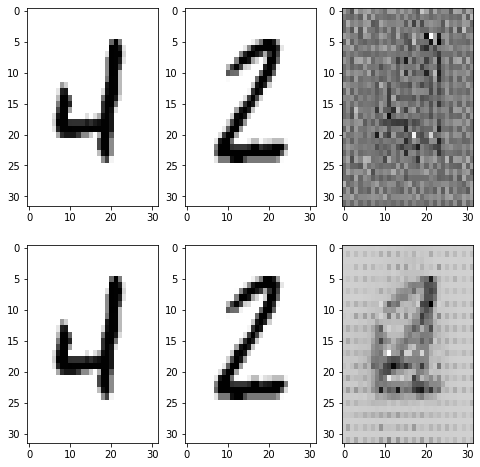

In [35]:
fig = plt.figure(figsize=(8, 8))
for targets in test_dataset.take(1):
    trg = targets["img"]
    inv = flow.bijector.inverse(trg)
    re_trg = flow.bijector.forward(inv)

print('log probability: ', tf.reduce_mean(tfd.Normal(0., 1.).log_prob(inv)).numpy())
print("inv mean: ", tf.reduce_mean(inv).numpy(), " std: ", tf.math.reduce_std(inv).numpy())
print("re:trg mean: ", tf.reduce_mean(re_trg).numpy(), " std: ", tf.math.reduce_std(re_trg).numpy())

re_inv = np.array([(inv[0] + inv[1]) / 2.0])
print(re_inv.shape)
re_re_trg = flow.bijector.forward(re_inv)

ax = fig.add_subplot(2, 3, 1)
ax.imshow(tf.squeeze(trg[0], axis=-1), aspect="auto", cmap="gray_r")

ax = fig.add_subplot(2, 3, 4)
ax.imshow(tf.squeeze(re_trg[0], axis=-1), aspect="auto", cmap="gray_r")

ax = fig.add_subplot(2, 3, 2)
ax.imshow(tf.squeeze(trg[1], axis=-1), aspect="auto", cmap="gray_r")

ax = fig.add_subplot(2, 3, 5)
ax.imshow(tf.squeeze(re_trg[1], axis=-1), aspect="auto", cmap="gray_r")

ax = fig.add_subplot(2, 3, 3)
ax.imshow(tf.squeeze(re_inv[0], axis=-1), aspect="auto", cmap="gray_r")

ax = fig.add_subplot(2, 3, 6)
ax.imshow(tf.squeeze(re_re_trg[0], axis=-1), aspect="auto", cmap="gray_r")